<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression or any other suitable classifier.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [23]:
URL = "https://www.indeed.com/jobs?q=data+science&l=New+York&start=2"

In [24]:
import numpy as np
import pandas as pd
import requests
import bs4
from bs4 import BeautifulSoup

In [25]:
## YOUR CODE HERE
r=requests.get(URL)
soup=BeautifulSoup(r.text,'html.parser')

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [26]:
# making the first scraper
import re

def fetching_data(soup=soup):
    lst=['location','companyInfoWrapper','turnstileLink','snip']
    data_dict={lst[0]:[],lst[1]:[],lst[2]:[],lst[3]:[]}
    
    for c in lst:
        for i in soup.find_all(attrs={'class':c}):
            if c=='snip':
                try:
                    data_dict[c].append(i.find(attrs={'class':'salary no-wrap'}).text.strip())
                except:
                    data_dict[c].append(None)
            elif c == 'companyInfoWrapper':
                try:
                    data_dict[c].append(i.find(attrs={'class':'company'}).text.strip())
                except:
                    data_dict[c].append(None)
            else:
                data_dict[c].append(i.text.strip())
    return data_dict

fetching_data()


{'location': ['New York, NY',
  'New York, NY 10036',
  'New York, NY 10011 (Chelsea area)',
  'New York, NY 10011 (Chelsea area)',
  'New York, NY 10036',
  'Jericho, NY',
  'New York, NY 10016 (Gramercy area)',
  'New York, NY 10174 (Murray Hill area)',
  'New York, NY',
  'New York, NY'],
 'companyInfoWrapper': ['Bloomberg',
  'Viacom',
  'Spotify',
  'Spotify',
  'DISNEY',
  'Publishers Clearing House',
  'Aetna',
  'UNOPS',
  'Liquidnet',
  'NBCUniversal'],
 'turnstileLink': ['Data Scientist',
  'Junior Data Scientist',
  'Data Scientist, Accounting',
  'Data Scientist, Infrastructure Engineering Insights',
  'Data Scientist, Retention',
  'Data Sciences Intern',
  'Data Scientist',
  'Data Science Assistant',
  'Junior Data Scientist/Quant Developer',
  'NBCUniversal Summer 2019 Data Science Internship – New York,...'],
 'snip': ['$119,000 - $175,000 a year (Indeed est.)',
  None,
  '$112,000 - $166,000 a year (Indeed est.)',
  '$120,000 - $177,000 a year (Indeed est.)',
  '$97,0

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [84]:
YOUR_CITY = 'Riyadh'

In [87]:
# bulding web scraper
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 100 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.
def crawler(max_results_per_city=100):
    results = []
    lst=['location','company','turnstileLink','snip']
    data_dict={lst[0]:[],lst[1]:[],lst[2]:[],lst[3]:[]}

    for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
        'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
        'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]):
        for start in range(0, max_results_per_city, 10):
            # Grab the results from the request (as above)
            # Append to the full set of results
            r=requests.get(url_template.format(city,start))
            soup=BeautifulSoup(r.text,'html.parser')
            for c in lst:
                for i in soup.find_all(attrs={'class':c}):
                    if c=='snip':
                        try:
                            data_dict[c].append(i.find(attrs={'class':'salary no-wrap'}).text.strip())
                        except:
                            data_dict[c].append(None)
                            
                    elif c == 'companyInfoWrapper':
                        
                        try:
                            data_dict[c].append(i.find(attrs={'class':'company'}).text.strip())
                        except:
                            data_dict[c].append(None)
        #            elif c == 'turnstileLink':
        #                data_dict[c].append(re.findall(r'title="(.+)"',str(i))[0])
                    else:
                        data_dict[c].append(i.text.strip())
    return data_dict
        

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [88]:
## YOUR CODE HERE
# scraping indeed
data_dict=crawler(max_results_per_city=1000)


In [97]:
# sanity check
len(data_dict['location'][:14921]),len(data_dict['company']),len(data_dict['turnstileLink']),len(data_dict['snip'])

(14921, 14921, 14921, 14921)

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [378]:
## YOUR CODE HERE
# filtering the salary-less and non-yearly salaries
import re
df=pd.DataFrame(data_dict)
df=df[~df.duplicated()]
df.columns=['location','company','job_title','salary']
df.salary=df.salary.map(lambda x: x if re.findall('year',str(x)) else None)
df.dropna(inplace=True)
df.head()

location                      company  \
181                                Dallas, TX                    Quisitive   
182                                Dallas, TX                     Givelify   
184  Dallas, TX 75246 (Northeast Dallas area)  Baylor Scott & White Health   
185                                Dallas, TX                         CBRE   
186                                Irving, TX            Kleinfelder, Inc.   

                                             job_title  \
181                                     O365 Architect   
182                             Senior Product Manager   
184  Research Post Doctorate Fellow - GI Cancer (Da...   
185                             Senior Product Manager   
186          Construction Materials Testing Technician   

                                       salary  
181   $96,000 - $145,000 a year (Indeed est.)  
182  $102,000 - $143,000 a year (Indeed est.)  
184    $40,000 - $55,000 a year (Indeed est.)  
185  $103,000 - $145,000 a year (Indeed est.)  
186    $29,000 - $41,000 a year (Indeed est.)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [379]:
## YOUR CODE HERE
# averaging the salaries with range while taking the ones without
def fixing_salaries(df):
    if re.findall('-',df):
        return (float(re.findall(r'-.\$(.*\s)a',df)[0].strip().replace(',',''))+float(str(re.findall('([1-9].*\s)-',df)[0]).strip().replace(',','')))/2
    else:
        return re.findall('\$(.*\s)a',df)[0].strip().replace(',','')
    
    
df.salary=df.salary.map(fixing_salaries)
df.reset_index(drop=True,inplace=True)
df.head()


location                      company  \
0                                Dallas, TX                    Quisitive   
1                                Dallas, TX                     Givelify   
2  Dallas, TX 75246 (Northeast Dallas area)  Baylor Scott & White Health   
3                                Dallas, TX                         CBRE   
4                                Irving, TX            Kleinfelder, Inc.   

                                           job_title  salary  
0                                     O365 Architect  120500  
1                             Senior Product Manager  122500  
2  Research Post Doctorate Fellow - GI Cancer (Da...   47500  
3                             Senior Product Manager  124000  
4          Construction Materials Testing Technician   35000

### Save your results as a CSV

In [380]:
# changing salary type to float
df.salary=df.salary.astype('float')

In [382]:
## YOUR CODE HERE
#df.to_csv('fixed_data.csv',index=False)

## QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your model's performance.

#### Load in the the data of scraped salaries

In [712]:
## YOUR CODE HERE
df=pd.read_csv('fixed_data.csv')
df_copy=df.copy()
df.head()

location                      company  \
0                                Dallas, TX                    Quisitive   
1                                Dallas, TX                     Givelify   
2  Dallas, TX 75246 (Northeast Dallas area)  Baylor Scott & White Health   
3                                Dallas, TX                         CBRE   
4                                Irving, TX            Kleinfelder, Inc.   

                                           job_title    salary  
0                                     O365 Architect  120500.0  
1                             Senior Product Manager  122500.0  
2  Research Post Doctorate Fellow - GI Cancer (Da...   47500.0  
3                             Senior Product Manager  124000.0  
4          Construction Materials Testing Technician   35000.0

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [713]:
## YOUR CODE HERE
#med=np.median(df.salary)

df['salary']=df_copy.salary.map(lambda x: 1 if x>np.median(df_copy.salary) else 0)
df['salary75']=df_copy.salary.map(lambda x: 1 if x>np.percentile(df_copy.salary,75) else 0)
df['salarymean']=df_copy.salary.map(lambda x: 1 if x>np.mean(df_copy.salary) else 0)

In [714]:
df.head()

location                      company  \
0                                Dallas, TX                    Quisitive   
1                                Dallas, TX                     Givelify   
2  Dallas, TX 75246 (Northeast Dallas area)  Baylor Scott & White Health   
3                                Dallas, TX                         CBRE   
4                                Irving, TX            Kleinfelder, Inc.   

                                           job_title  salary  salary75  \
0                                     O365 Architect       1         1   
1                             Senior Product Manager       1         1   
2  Research Post Doctorate Fellow - GI Cancer (Da...       0         0   
3                             Senior Product Manager       1         1   
4          Construction Materials Testing Technician       0         0   

   salarymean  
0           1  
1           1  
2           0  
3           1  
4           0

#### Thought experiment: What is the baseline accuracy for this model?

In [715]:
## YOUR CODE HERE
df.groupby('salary').count()

location  company  job_title  salary75  salarymean
salary                                                    
0            224      224        224       224         224
1            223      223        223       223         223

In [716]:
# making the accuracy dictionary
accuracy_dict={'model':[],
               'features':[],
               'split':[],
               'accuracy':[]}

for i,k in zip([1-df.salary.mean(),1-df['salary75'].mean(),1-df['salarymean'].mean()],['median','75th','mean']):
    accuracy_dict['model'].append('baseline')
    accuracy_dict['features'].append('None')
    accuracy_dict['split'].append(k)
    accuracy_dict['accuracy'].append(i)

In [717]:
pd.DataFrame(accuracy_dict)

model features   split  accuracy
0  baseline     None  median  0.501119
1  baseline     None    75th  0.753915
2  baseline     None    mean  0.539150

### Create a classification model to predict High/Low salary. 


#### Model based on location:

- Start by ONLY using the location as a feature. 
- Use logistic regression with both statsmodels and sklearn.
- Use a further classifier you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.

#### Model taking into account job levels and categories:

- Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value? 
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. 
- Discuss model coefficients or feature importances as applicable.

#### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 


- Use cross-validation to evaluate your models. 
- Evaluate the accuracy, AUC, precision and recall of the models. 
- Plot the ROC and precision-recall curves for at least one of your models.

#### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

## Model based on location:

In [718]:
## YOUR CODE HERE
# model based on location only
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
lm=LogisticRegression()

for i,k in zip(['salary','salary75','salarymean'],['median','75th','mean']):
    X=pd.get_dummies(df.location,drop_first=True)
    y=df[i]
    X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=11037,test_size=0.2)
    lm.fit(X_train,y_train)
    score=lm.score(X_test,y_test)
    accuracy_dict['model'].append('Logistic Regression')
    accuracy_dict['features'].append('Location')
    accuracy_dict['split'].append(k)
    accuracy_dict['accuracy'].append(score)
pd.DataFrame(accuracy_dict)

model  features   split  accuracy
0             baseline      None  median  0.501119
1             baseline      None    75th  0.753915
2             baseline      None    mean  0.539150
3  Logistic Regression  Location  median  0.711111
4  Logistic Regression  Location    75th  0.822222
5  Logistic Regression  Location    mean  0.777778

In [719]:
# feature importance in descending order. tha higher the absolute value of the coeff the bigger its impact.
pd.DataFrame(abs(lm.coef_),columns=X.columns).sort_values(0,axis=1,ascending=False)

San Francisco, CA  Manhattan, NY  Pittsburgh, PA  Queens, NY  Dallas, TX  \
0           2.018957       1.791511        1.608686    1.569861    1.527632   

   Fort Lauderdale, FL  San Francisco, CA 94105 (Financial District area)  \
0               1.3488                                           1.335012   

   Roswell, GA  San Francisco, CA 94103 (South Of Market area)  \
0     1.250594                                        1.217482   

   Los Angeles, CA        ...         \
0         1.128162        ...          

   Denver, CO 80237 (Southeastern Denver area)  \
0                                          0.0   

   Houston, TX 77056 (Galleria-Uptown area)  Long Beach, CA 90805  \
0                                       0.0                   0.0   

   Los Angeles, CA 90028  Los Angeles, CA 90035  Melrose Park, IL 60160  \
0                    0.0                    0.0                     0.0   

   New York, NY 10017 (Midtown area)  Newtown, PA  Norcross, GA  \
0                                0.0          0.0           0.0   

   Itasca, IL 60143  
0               0.0  

[1 rows x 126 columns]

In [720]:
# another classificer based on location only
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
nb=MultinomialNB()
for i,k in zip(['salary','salary75','salarymean'],['median','75th','mean']):
    X=pd.get_dummies(df.location,drop_first=True)
    y=df[i]
    X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=11037,test_size=0.2)
    nb.fit(X_train,y_train)
    score=nb.score(X_test,y_test)
    accuracy_dict['model'].append('Naive Bayes')
    accuracy_dict['features'].append('Location')
    accuracy_dict['split'].append(k)
    accuracy_dict['accuracy'].append(score)
pd.DataFrame(accuracy_dict)

model  features   split  accuracy
0             baseline      None  median  0.501119
1             baseline      None    75th  0.753915
2             baseline      None    mean  0.539150
3  Logistic Regression  Location  median  0.711111
4  Logistic Regression  Location    75th  0.822222
5  Logistic Regression  Location    mean  0.777778
6          Naive Bayes  Location  median  0.711111
7          Naive Bayes  Location    75th  0.888889
8          Naive Bayes  Location    mean  0.777778

## Model taking into account job levels and categories:

In [721]:
# making up new features
df['senior']=df.job_title.map(lambda x: 1 if re.findall('Senior',x) else 0)
df['manager']=df.job_title.map(lambda x: 1 if re.findall('Manager',x) else 0)
df['Engineer']=df.job_title.map(lambda x: 1 if re.findall('Engineer',x) else 0)
df['Data_Science']=df.job_title.map(lambda x: 1 if re.findall('Data Scientist',x) or re.findall('Data Science',x) else 0)


In [722]:
# testing out the features one by one
lst=[]
for i in ['senior','manager','Engineer','Data_Science']:
    X=pd.get_dummies(df[[i,'job_title']])
    y=df.salary
    X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=11037,test_size=0.2)
    lm=LogisticRegression()
    lm.fit(X_train,y_train)
    lst.append(lm.score(X_test,y_test))
print('senior and job_title accuracy      :',lst[0])
print('manager and job_title accuracy     :',lst[1])
print('Engineer and job_title accuracy    :',lst[2])
print('Data_Science and job_title accuracy:',lst[3])

senior and job_title accuracy      : 0.6777777777777778
manager and job_title accuracy     : 0.6777777777777778
Engineer and job_title accuracy    : 0.7444444444444445
Data_Science and job_title accuracy: 0.8222222222222222


In [723]:
# testing out the model in all features

for i,k in zip(['salary','salary75','salarymean'],['median','75th','mean']):
    X=pd.get_dummies(df[['senior','manager','Engineer','Data_Science','job_title','location']])
    y=df[i]
    X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=11037,test_size=0.2)
    lm.fit(X_train,y_train)
    score=lm.score(X_test,y_test)
    accuracy_dict['model'].append('Logistic Regression')
    accuracy_dict['features'].append('all')
    accuracy_dict['split'].append(k)
    accuracy_dict['accuracy'].append(score)
pd.DataFrame(accuracy_dict)


model  features   split  accuracy
0              baseline      None  median  0.501119
1              baseline      None    75th  0.753915
2              baseline      None    mean  0.539150
3   Logistic Regression  Location  median  0.711111
4   Logistic Regression  Location    75th  0.822222
5   Logistic Regression  Location    mean  0.777778
6           Naive Bayes  Location  median  0.711111
7           Naive Bayes  Location    75th  0.888889
8           Naive Bayes  Location    mean  0.777778
9   Logistic Regression       all  median  0.877778
10  Logistic Regression       all    75th  0.888889
11  Logistic Regression       all    mean  0.877778

In [724]:
# we can see that the two features i added before had high impact.
pd.DataFrame(abs(lm.coef_),columns=X.columns).sort_values(0,axis=1,ascending=False)

Data_Science  location_Dallas, TX  location_San Francisco, CA  Engineer  \
0      2.332827             1.614821                    1.490894  1.267473   

   location_Fort Lauderdale, FL  location_Manhattan, NY  \
0                      1.246617                1.233155   

   location_Pittsburgh, PA  location_Phoenix, AZ  location_Miami, FL  \
0                  1.22669              1.146758            1.042823   

   location_Chicago, IL 60607 (Near West Side area)  \
0                                          1.028644   

               ...                location_Los Angeles, CA 90028  \
0              ...                                           0.0   

   job_title_Machine Learning Software Developer  \
0                                            0.0   

   location_Long Beach, CA 90805  job_title_Machinist Prototype Sr - (664396)  \
0                            0.0                                          0.0   

   location_Itasca, IL 60143  \
0                        0.0   

   job_title_Medical Lab Assistant - PT Weekend Nights  \
0                                                0.0     

   location_Houston, TX 77056 (Galleria-Uptown area)  \
0                                                0.0   

   job_title_Planning and Research Analyst (South Mountain Community Coll...  \
0                                                0.0                           

   job_title_Policy Data Analyst  job_title_Risk Data Scientist  
0                            0.0                            0.0  

[1 rows x 440 columns]

## Model evaluation:

In [725]:
# Logistic Regression evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc,precision_score,recall_score
lm=LogisticRegression(C=1)
print('Cross-validation. LogisticRegression:',cross_val_score(lm,X_train,y_train,cv=10).mean())
print('precision. LogisticRegression       :',precision_score(y_test,lm.fit(X_train,y_train).predict(X_test)))
print('recall. LogisticRegression          :',recall_score(y_test,lm.fit(X_train,y_train).predict(X_test)))
fpr, tpr, threshold = roc_curve(y_test, lm.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print('AUC                                 :',roc_auc)

Cross-validation. LogisticRegression: 0.8572829131652661
precision. LogisticRegression       : 0.8857142857142857
recall. LogisticRegression          : 0.8157894736842105
AUC                                 : 0.9276315789473684


In [726]:
# Random Forest evaluation focused in precision (lower False Positives)
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
print('Cross-validation. Random Forest:',cross_val_score(rf,X_train,y_train,cv=10).mean())
print('precision. Random Forest       :',precision_score(y_test,rf.fit(X_train,y_train).predict(X_test)))
print('recall. Random Forest          :',recall_score(y_test,rf.fit(X_train,y_train).predict(X_test)))
fpr, tpr, threshold = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print('AUC                            :',roc_auc)

Cross-validation. Random Forest: 0.8428197945845006
precision. Random Forest       : 0.9117647058823529
recall. Random Forest          : 0.7105263157894737
AUC                            : 0.895495951417004


In [727]:
for i,k in zip(['salary','salary75','salarymean'],['median','75th','mean']):
    X=pd.get_dummies(df[['senior','manager','Engineer','Data_Science','job_title','location']])
    y=df[i]
    X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=11037,test_size=0.2)
    rf.fit(X_train,y_train)
    score=rf.score(X_test,y_test)
    accuracy_dict['model'].append('Random Forest')
    accuracy_dict['features'].append('all')
    accuracy_dict['split'].append(k)
    accuracy_dict['accuracy'].append(score)
pd.DataFrame(accuracy_dict)

model  features   split  accuracy
0              baseline      None  median  0.501119
1              baseline      None    75th  0.753915
2              baseline      None    mean  0.539150
3   Logistic Regression  Location  median  0.711111
4   Logistic Regression  Location    75th  0.822222
5   Logistic Regression  Location    mean  0.777778
6           Naive Bayes  Location  median  0.711111
7           Naive Bayes  Location    75th  0.888889
8           Naive Bayes  Location    mean  0.777778
9   Logistic Regression       all  median  0.877778
10  Logistic Regression       all    75th  0.888889
11  Logistic Regression       all    mean  0.877778
12        Random Forest       all  median  0.877778
13        Random Forest       all    75th  0.911111
14        Random Forest       all    mean  0.833333

In [728]:
# Naive Bayes evaluation
nb=MultinomialNB()
print('Cross-validation. Naive Bayes:',cross_val_score(nb,X_train,y_train,cv=10).mean())
print('precision. Naive Bayes       :',precision_score(y_test,nb.fit(X_train,y_train).predict(X_test)))
print('recall. Naive Bayes          :',recall_score(y_test,nb.fit(X_train,y_train).predict(X_test)))
fpr, tpr, threshold = roc_curve(y_test, nb.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print('AUC                          :',roc_auc)

Cross-validation. Naive Bayes: 0.8569561157796451
precision. Naive Bayes       : 0.8048780487804879
recall. Naive Bayes          : 0.868421052631579
AUC                          : 0.9132085020242915


In [729]:
for i,k in zip(['salary','salary75','salarymean'],['median','75th','mean']):
    X=pd.get_dummies(df[['senior','manager','Engineer','Data_Science','job_title','location']])
    y=df[i]
    X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=11037,test_size=0.2)
    nb.fit(X_train,y_train)
    score=nb.score(X_test,y_test)
    accuracy_dict['model'].append('Naive Bayes')
    accuracy_dict['features'].append('all')
    accuracy_dict['split'].append(k)
    accuracy_dict['accuracy'].append(score)
pd.DataFrame(accuracy_dict)

model  features   split  accuracy
0              baseline      None  median  0.501119
1              baseline      None    75th  0.753915
2              baseline      None    mean  0.539150
3   Logistic Regression  Location  median  0.711111
4   Logistic Regression  Location    75th  0.822222
5   Logistic Regression  Location    mean  0.777778
6           Naive Bayes  Location  median  0.711111
7           Naive Bayes  Location    75th  0.888889
8           Naive Bayes  Location    mean  0.777778
9   Logistic Regression       all  median  0.877778
10  Logistic Regression       all    75th  0.888889
11  Logistic Regression       all    mean  0.877778
12        Random Forest       all  median  0.877778
13        Random Forest       all    75th  0.911111
14        Random Forest       all    mean  0.833333
15          Naive Bayes       all  median  0.833333
16          Naive Bayes       all    75th  0.866667
17          Naive Bayes       all    mean  0.855556

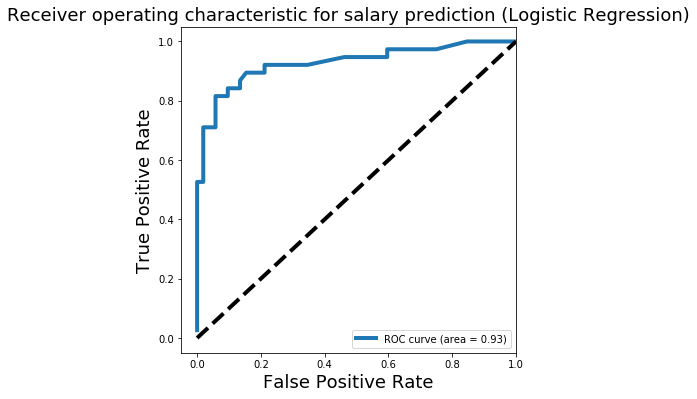

In [730]:
# ploting the ROC curve for Logistic Regression
from sklearn.metrics import roc_curve,auc,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
# For class 1, find the area under the curve
fpr, tpr, threshold = roc_curve(y_test, lm.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 
plt.figure(figsize=[6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for salary prediction (Logistic Regression)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Average precision-recall score: 0.93


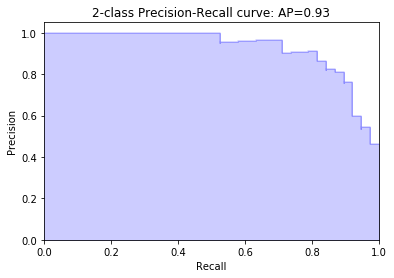

In [731]:
# ploting the Precision-Recall curve for Logistic Regression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test,lm.predict_proba(X_test)[:,1])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, _ = precision_recall_curve(y_test,lm.predict_proba(X_test)[:,1])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

#### The project includes three main parts that i went through as follows:
1-Data Collection.<br/>
2-Data Cleaning.<br/>
3-Modeling.<br/>

Data Collection: I made a web crawler and scraped the job posting website Indeed to get my data.<br/><br/>
Data Cleaning: after fetching the data, i filtered the job postings that doesn't have salaries along with non-yearly salaries. then changed the salary columns into low or high format using the median, 75th percentile, and mean as splitters.<br/><br/>
Modeling: I used multiple models to see out how it compares to the average model (baseline). see the report below.

In [739]:
pd.DataFrame(accuracy_dict).groupby(['features','model','split'],sort=False).mean()

accuracy
features model               split           
None     baseline            median  0.501119
                             75th    0.753915
                             mean    0.539150
Location Logistic Regression median  0.711111
                             75th    0.822222
                             mean    0.777778
         Naive Bayes         median  0.711111
                             75th    0.888889
                             mean    0.777778
all      Logistic Regression median  0.877778
                             75th    0.888889
                             mean    0.877778
         Random Forest       median  0.877778
                             75th    0.911111
                             mean    0.833333
         Naive Bayes         median  0.833333
                             75th    0.866667
                             mean    0.855556

We can see above that the models scored better than the baseline in all cases, while the accuracy is not bad given more time and data i believe that i can reach even higher accuracy.

#### Risks:
In the case of 75th percntile the model may give low salary to all and still reaches good accuracy, so we need to be carefull when dealing with accuracy alone.<br/>

#### Limitations
In our model we predicted wither the salary is high or low and not the exact number, our models gave us a good accuracy but without the exact number. so for us to make a more useful model, i may need to consider multiple levels of the salary or go for the exact number as a Regression task.

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 